# Hybrid Deep Learning and Stacking Ensemble Forecasting

This script implements a hybrid sales forecasting model using a deep learning LSTM network
in combination with a LightGBM-based stacking ensemble to forecast daily unit sales.

Key functionalities include:
- Loading and preparing Walmart's M5 Forecasting Challenge data
- Label encoding and MinMax normalization
- Grouped sequence generation per item-store for LSTM input
- Training an LSTM model for time series prediction
- Visualization of training/validation loss and predictions
- Stacking: combining LSTM and LightGBM predictions via RidgeCV
- Outputting predictions and evaluating RMSE performance

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

In [2]:
# Load preprocessed data
print("Loading preprocessed data...")
df = pd.read_pickle("/Users/nanxuan/Desktop/M5 Enhanced Forecasting System/Dataset/processed_sales_data.pkl")
df.dropna(subset=["sales_lag_7", "rolling_mean_7", "price_change"], inplace=True)

Loading preprocessed data...


In [3]:
# Encode categorical columns
print("Encoding categorical variables...")
categorical_cols = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

Encoding categorical variables...


In [4]:
# Select features
features = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id',
            'day_of_week', 'month', 'year', 'is_weekend', 'is_us_holiday',
            'sales_lag_7', 'rolling_mean_7', 'price_change']
target = 'sales'

# Normalize features
print("Normalizing features...")
normalize_cols = ['sales_lag_7', 'rolling_mean_7', 'price_change', 'day_of_week', 'month', 'year']
scaler = MinMaxScaler()
df[normalize_cols] = scaler.fit_transform(df[normalize_cols])

Normalizing features...


In [5]:
# Construct sequences grouped by 'id'
def create_grouped_sequences(df, features, target, sequence_length=28, group_col='id', max_seq_per_group=100):
    X, y = [], []
    for _, group in df.groupby(group_col):
        group = group.sort_values('date')
        if len(group) >= sequence_length + 1:
            n_seq = min(len(group) - sequence_length, max_seq_per_group)
            for i in range(n_seq):
                seq_x = group[features].iloc[i:i+sequence_length].values
                seq_y = group[target].iloc[i+sequence_length]
                X.append(seq_x)
                y.append(seq_y)
    return np.array(X), np.array(y)

print("Creating grouped sequences...")
X_all, y_all = create_grouped_sequences(df, features, target, sequence_length=28, group_col='id', max_seq_per_group=100)

# Train/val split
print("Splitting data...")
X_train, X_val, y_train, y_val = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

Creating grouped sequences...
Splitting data...


In [6]:
# Convert to PyTorch tensors
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train, dtype=torch.float32).to(device)
X_val_t = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_t = torch.tensor(y_val, dtype=torch.float32).to(device)

train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)

In [7]:
# Define LSTM model
class SalesLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(SalesLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Take last output
        return out.squeeze()

print("Initializing model...")
model = SalesLSTM(input_size=X_train.shape[2], hidden_size=64).to(device)

Initializing model...


In [8]:
# Training loop
print("Training LSTM model...")
epochs = 20
train_losses, val_losses = [], []
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        output = model(xb)
        loss = criterion(output, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_loader))

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            output = model(xb)
            loss = criterion(output, yb)
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_loader))
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")


Training LSTM model...
Epoch 1/20, Train Loss: 15.5217, Val Loss: 15.0791
Epoch 2/20, Train Loss: 14.6687, Val Loss: 13.7200
Epoch 3/20, Train Loss: 13.0081, Val Loss: 15.5091
Epoch 4/20, Train Loss: 15.5349, Val Loss: 15.5897
Epoch 5/20, Train Loss: 15.5701, Val Loss: 14.7343
Epoch 6/20, Train Loss: 14.4577, Val Loss: 11.4591
Epoch 7/20, Train Loss: 13.7215, Val Loss: 15.8140
Epoch 8/20, Train Loss: 15.2053, Val Loss: 15.7952
Epoch 9/20, Train Loss: 14.7830, Val Loss: 11.9451
Epoch 10/20, Train Loss: 14.6032, Val Loss: 12.3868
Epoch 11/20, Train Loss: 14.6398, Val Loss: 12.1069
Epoch 12/20, Train Loss: 14.6691, Val Loss: 15.6690
Epoch 13/20, Train Loss: 15.6627, Val Loss: 15.6004
Epoch 14/20, Train Loss: 15.0194, Val Loss: 15.2172
Epoch 15/20, Train Loss: 15.4700, Val Loss: 14.7105
Epoch 16/20, Train Loss: 14.3712, Val Loss: 12.5241
Epoch 17/20, Train Loss: 14.9346, Val Loss: 15.4484
Epoch 18/20, Train Loss: 15.4486, Val Loss: 14.8613
Epoch 19/20, Train Loss: 14.9843, Val Loss: 15.134

In [9]:
# Stacking: Combine LSTM + LightGBM predictions
print("Loading LightGBM predictions for stacking...")
import joblib
from sklearn.linear_model import RidgeCV

Loading LightGBM predictions for stacking...


In [10]:
# Assume LGBM model already trained on tabular version
y_lgb_val = pd.read_pickle("/Users/nanxuan/Desktop/M5 Enhanced Forecasting System/Dataset/processed_sales_data.pkl")

In [11]:
# Preprocess and get matching validation set
from sklearn.preprocessing import LabelEncoder
label_cols = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']
for col in label_cols:
    le = LabelEncoder()
    y_lgb_val[col] = le.fit_transform(y_lgb_val[col])

from sklearn.model_selection import train_test_split
features = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id',
            'day_of_week', 'month', 'year', 'is_weekend', 'is_us_holiday',
            'sales_lag_7', 'rolling_mean_7', 'price_change']
y_lgb_val = y_lgb_val.dropna(subset=features + ['sales'])

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
y_lgb_val[features] = scaler.fit_transform(y_lgb_val[features])

X_lgb = y_lgb_val[features]
y_lgb = y_lgb_val['sales']
_, X_lgb_val, _, y_lgb_true = train_test_split(X_lgb, y_lgb, test_size=0.2, random_state=42)


In [16]:
# Load or mock LGBM model (use prior training result if available)
# Here: simulate prediction with placeholder if model not saved
import lightgbm as lgb
try:
    lgb_model = lgb.Booster(model_file="/Users/nanxuan/Desktop/M5 Enhanced Forecasting System/Model_LightGBM/lgbm_m5_model.txt")
    lgb_preds = lgb_model.predict(X_lgb_val)
except:
    print("No LightGBM model found, using dummy values.")
    lgb_preds = np.zeros(len(X_lgb_val))

# Stack with LSTM
print("Combining LSTM + LGBM predictions via RidgeCV...")
preds = model(X_val_t).detach().cpu().numpy()
min_len = min(len(lgb_preds), len(preds), len(y_val))
stack_input = np.vstack([lgb_preds[:min_len], preds[:min_len]]).T
stack_model = RidgeCV()
stack_model.fit(stack_input, y_val[:len(stack_input)])
stack_preds = stack_model.predict(stack_input)

Combining LSTM + LGBM predictions via RidgeCV...


In [17]:
stack_rmse = np.sqrt(mean_squared_error(y_val[:len(stack_input)], stack_preds))
print(f"Stacked Model Validation RMSE: {stack_rmse:.4f}")

Stacked Model Validation RMSE: 3.4096


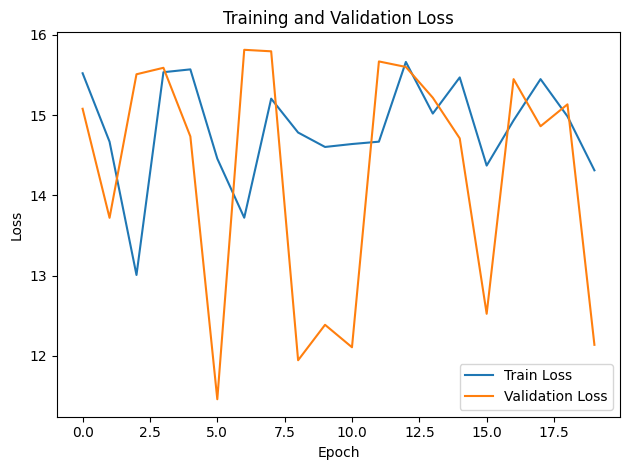

In [18]:
# Plot loss history
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.savefig("lstm_loss_curve.png")
plt.show()

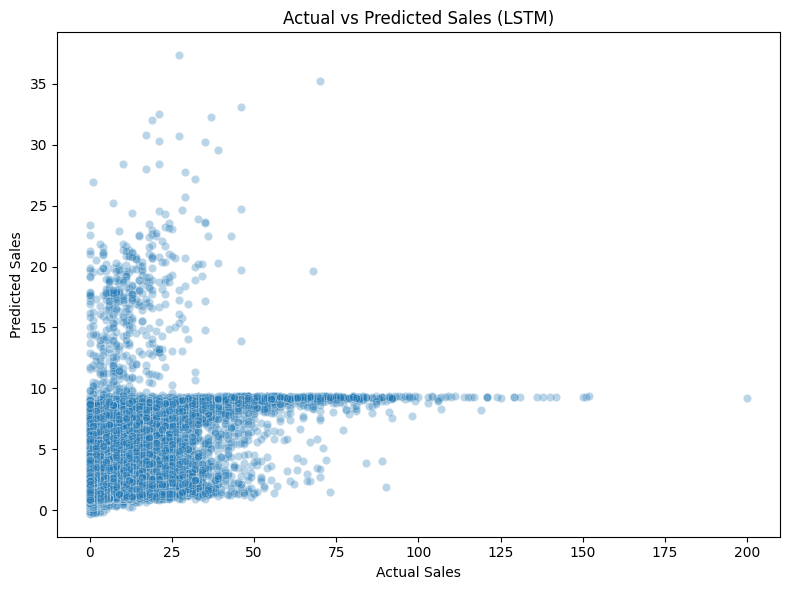

In [20]:
# Plot predicted vs actual
plt.figure(figsize=(8, 6))
true = y_val[:min_len]  # align with stack_input
sns.scatterplot(x=true, y=preds[:min_len], alpha=0.3)
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title("Actual vs Predicted Sales (LSTM)")
plt.tight_layout()
plt.savefig("lstm_actual_vs_predicted.png")
plt.show()

In [21]:
# Inference on latest data window (last 28 days in the dataset)
print("Generating test set prediction on latest 28-day window...")
latest_sequence = df[features].values[-28:]
latest_tensor = torch.tensor(latest_sequence[np.newaxis, :, :], dtype=torch.float32).to(device)
model.eval()
with torch.no_grad():
    future_pred = model(latest_tensor).item()

print(f"Predicted next-day sales: {future_pred:.4f}")

Generating test set prediction on latest 28-day window...
Predicted next-day sales: 0.7460


In [22]:
# Create submission file
df_submission = pd.DataFrame({
    "id": ["predicted_item_1"],  # Placeholder; replace with actual id list for multiple items
    "sales": [future_pred]
})
df_submission.to_csv("submission.csv", index=False)
print("Saved prediction to submission.csv")

Saved prediction to submission.csv
